## Checkee.info Data Analysis
Some very simple data analysis of the scraped data from [Checkee.info](http://checkee.info/).

I am also using this data set to practice how to use the Pandas library in Python 3.

*Note that due to the limitations of the dataset, the results are not likely to be reliable and can only be used as an overview.*

In [1]:
# Make sure plots are inline
%matplotlib inline

# xlrd to read .xlsx sheet data
import xlrd
from xlrd.xldate import xldate_as_datetime

# Import Pandas library
import pandas as pd

# Import matplotlib
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import stats methods for statistical analysis
from scipy.stats import norm, normaltest, gamma

In [2]:
# Read scraped datasheet
workbook = xlrd.open_workbook('VISA-Data-2017-03-04.xlsx')
booksheet = workbook.sheet_by_index(0)

# Get data fields
startRow = 5 - 1
userID = booksheet.col_values(0,startRow)
visaType = booksheet.col_values(2,startRow)
visaEntry = booksheet.col_values(3,startRow)
city = booksheet.col_values(4,startRow)
waitDays = booksheet.col_values(9,startRow)

# By default, xlrd will read the date fields into numeric values (xldate type)
# So here I need to convert xldate into datetime type
dateNum = booksheet.col_values(7,startRow)
checkDate = []
for item in dateNum:
    checkDate.append(xldate_as_datetime(item,0))

In [3]:
# Assemble all the data into a Pandas.DataFrame object
df = pd.DataFrame({
        'userID'    : pd.Series(userID),
        'visaType'  : pd.Categorical(visaType),
        'visaEntry' : pd.Categorical(visaEntry),
        'city'      : pd.Categorical(city),
        'checkDate' : checkDate,
        'waitDays'  : pd.Series(waitDays)
        })

# Use userID as the index
df = df.set_index('userID')

# Show raw data
df.tail()

,checkDate,city,visaEntry,visaType,waitDays
userID,,,,,
16299.0,2017-02-21,ShangHai,New,H1,6.0
16300.0,2017-02-22,BeiJing,New,H1,2.0
16301.0,2017-02-24,BeiJing,New,F1,4.0
16302.0,2017-02-27,ShangHai,New,H1,1.0
16303.0,2017-02-27,GuangZhou,Renewal,F1,1.0


As shown above, the raw data includs a couple of fields:
- **checkDate** - When the applicant applied for visa
- **city** - Where did the application submitted
- **userID** - An unique annonymous user identifier
- **visaEntry** - Is the application new or renewal
- **visaType** - Type of visa applied
- **waitDays** - How long did it take to finally get the visa

Note that all the data here are those marked as complete.

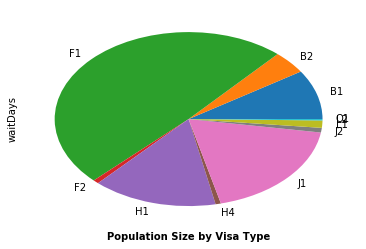

In [4]:
# Group data by Visa Type
vt = df.groupby('visaType')

# Get waiting days data
wd = vt['waitDays']

# Summarize Data Population
ax1 = wd.count().plot(kind='pie')
plt.xlabel('Population Size by Visa Type',fontweight='bold')

Facts based on population:
- F1 visa have most records ($n=7992$)
- J1 has the second largest records ($n=3039$), followed by H1 ($n=2454$)
- B1 and B2 together has $n=2189$ records.

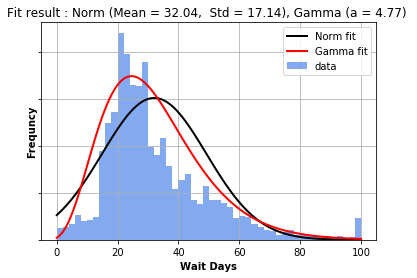

In [5]:
# Get F1 Visa waiting days data
wdF1 = wd.get_group('F1')

# Clip irregular values
wdF1 = wdF1.clip_upper(100)

# Try to fit a normal distribution
mu, std = norm.fit(wdF1.values)
# and gamma distribution
a, l, s = gamma.fit(wdF1.values)

# Plot histogram overlayed with normal distribution fit
wdF1.hist(bins=50, normed=True, alpha=0.8, color='#6495ED')
plt.xlabel('Wait Days',fontweight='bold')
plt.ylabel('Frequncy',fontweight='bold')
# overlay - Normal Distribution
x = np.linspace(0, 100, 100)
p = norm.pdf(x, mu, std) * 1.3
plt.plot(x, p, 'k', linewidth=2)
title = "Fit result : Norm (Mean = %.2f,  Std = %.2f), Gamma (a = %.2f) " % (mu, std, a)
plt.title(title)
# overlay - Gamma Distribution
p = gamma.pdf(x, a, loc=l, scale=s) * 1.3
plt.plot(x, p, 'r', linewidth=2)

plt.legend(['Norm fit','Gamma fit','data'])
plt.tick_params(labelleft='off')
plt.show()

In [6]:
# Let's first make sure it comes from a normal distribution by conducting a Chi-squared test
_, pval = normaltest(wdF1.values)
print('Chi-Squared test p = %.10f' % pval)

# Estimate 95% confidence interval by taking [mu-2*SE, mu+2*SE] (assume normal distribution)
interval = norm.interval(0.95, loc=mu, scale=std/np.sqrt(wdF1.count()))
print('95%% CI of waiting days: (%.3f, %.3f)' % (interval[0], interval[1]))

Chi-Squared test p = 0.0000000000
95% CI of waiting days: (31.667, 32.419)


The plot above shows the histogram and fitted distribution based on all the F1 visa records available ($n=7992$). Here are some interpretations:
- Sample mean ($\mu=32.04$) suggest the the average waiting days for F1 visa applicant being checked is around 32.04 days. Specifically, 95% confidence interval is **(31.667, 32.419) days**
- Sample has a rather large standard deviation ($\sigma=17.14$). One standard deviation range ($\mu\pm\sigma$, *i.e.* ~68% of the population) is (14.9, 49.18) days which is about **2 to 7 weeks**. In addition, two standard deviation range ($\mu\pm2\sigma$, *i.e.* ~95% of the population) is (-2.24, 66.33) days which is about **0 to 9 weeks**.
- Based on the fitted curves, a gamma (skewed distribution) looks visually better than a normal fit which implies two things. First, the mean is skewed towards the left means there are more people get cleared within 32 days (sample mean). Second, distribution has a rather long tail on the right which suggest those people like me who unformatunately got checked longer than the mean **tend to be very long (e.g. I got checked for 49 days)**.